In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from __future__ import division
from sklearn.metrics import confusion_matrix,recall_score,precision_recall_curve,auc,roc_curve,roc_auc_score,classification_report
from sklearn.model_selection import KFold

In [5]:
df = pd.read_csv('dataset/creditcard.csv')
df_fe = df.drop(['V8','V13','V15','V20','V22','V23','V24','V25','V26','V27','V28'], axis =1)

In [6]:
count_normal_transacation = len(df_fe[df_fe["Class"]==0]) # normal transaction are repersented by 0
count_fraud_transacation = len(df_fe[df_fe["Class"]==1]) # fraud by 1
fraud_indices = np.array(df_fe[df_fe.Class==1].index)
normal_indices = np.array(df_fe[df_fe.Class==0].index)

#now let us a define a function for make undersample data with different proportion
#different proportion means with different proportion of normal classes of data

def undersample(df, normal_indices, fraud_indices, multiple): # multiple denote the normal data = multiple * fraud data
    normal_indices_undersample = np.array(np.random.choice(normal_indices,(multiple*count_fraud_transacation),replace=False))
    undersample_data = np.concatenate([fraud_indices, normal_indices_undersample])
    undersample_data = df.iloc[undersample_data,:]
    
    print "the normal transacation proportion is :", len(undersample_data[undersample_data.Class==0])/len(undersample_data)
    print "the fraud transacation proportion is :", len(undersample_data[undersample_data.Class==1])/len(undersample_data)
    print "total number of record in resampled data is:",len(undersample_data)
    return(undersample_data)

In [7]:
def prediction_algorithms(model, features_train, features_test, labels_train, labels_test):
    model.fit(features_train, labels_train.values.ravel())
    pred = model.predict(features_test)
    cm = confusion_matrix(labels_test,pred)
    recall = cm[1,1] / (cm[1,1] + cm[1,0])
    precision = cm[1,1] / (cm[1,1] + cm[0,1])
    print "the recall for this model is :", recall
    print "The accuracy is :", (cm[1,1]+cm[0,0])/(cm[0,0] + cm[0,1] + cm[1,0] + cm[1,1])
    loss = (1 - precision) * 88.29 + (1 - recall) * 122.12
    fig= plt.figure(figsize=(6,3))# to plot the graph
    print "TP",cm[1,1] # no of fraud transaction which are predicted fraud
    print "TN",cm[0,0] # no. of normal transaction which are predited normal
    print "FP",cm[0,1] # no of normal transaction which are predicted fraud
    print "FN",cm[1,0] # no of fraud Transaction which are predicted normal
    sns.heatmap(cm, cmap="coolwarm_r", annot=True, linewidths=0.5)
    plt.title("Confusion_matrix")
    plt.xlabel("Predicted_class")
    plt.ylabel("Real class")
    plt.show()
    print "Classification Report:" 
    print(classification_report(labels_test,pred))
    print "The loss is : ", loss

In [8]:
def custom_loss_fuction(model,features_train,features_test,labels_train,labels_test):
    model.fit(features_train,labels_train.values.ravel())
    pred = model.predict(features_test)
    cm = confusion_matrix(labels_test,pred)
    recall = cm[1,1] / (cm[1,1] + cm[1,0])
    precision = cm[1,1] / (cm[1,1] + cm[0,1])
    loss = (1 - precision) * 88.29 + (1 - recall) * 122.12
    return loss

## Tuning hyperparameters using custom grid-search like methods with 5-fold cv
***

### Logistic Regression 
#### C, penalty
***

In [9]:
undersample_data_lr = undersample(df, normal_indices,fraud_indices, 132)
X_undersample_lr = undersample_data_lr.iloc[:, undersample_data_lr.columns != "Class"]
y_undersample_lr = undersample_data_lr.iloc[:, undersample_data_lr.columns == "Class"]
X_undersample_train_lr, X_undersample_test_lr, y_undersample_train_lr, y_undersample_test_lr = train_test_split(X_undersample_lr, y_undersample_lr, random_state=0)
X_lr = df.iloc[:, df.columns != "Class"]
y_lr = df.iloc[:, df.columns == "Class"]
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr, y_lr, random_state=0) 

the normal transacation proportion is : 0.992481203008
the fraud transacation proportion is : 0.00751879699248
total number of record in resampled data is: 65436


In [10]:
def Kfold_tuning_lr(X_train_data, y_train_data):
    fold = KFold(n_splits=5, shuffle=False, random_state=0) 

    c_param_range = [0.01, 0.1, 1, 10, 100]
    penalties = ['l1', 'l2']

    penalty_list = []
    c_list = []
    mean_loss_list = []
    
    j = 0
    for penalty in penalties:
        print '-------------------------------------------'
        print 'Penalty: ', penalty 
        print '-------------------------------------------'
        for c_param in c_param_range:
            print '-------------------------------------------'
            print 'C parameter: ', c_param
            print '-------------------------------------------'
            print ''

            loss_list = []
            for k, (train, test) in enumerate(fold.split(X_train_data, y_train_data)):

                # Call the logistic regression model with a certain C parameter
                lr = LogisticRegression(C=c_param, penalty=penalty, random_state=0)

                # Calculate the custom loss and append it to a list for loss representing the current c_parameter
                loss = custom_loss_fuction(lr, X_train_data.iloc[train], X_test_lr, y_train_data.iloc[train], y_test_lr)
                loss_list.append(loss)
                print 'Fold ', k + 1,': loss = ', loss

            j += 1
            print ''
            print 'Mean loss', np.mean(loss_list)
            print ''
            penalty_list.append(penalty)
            c_list.append(c_param)
            mean_loss_list.append(np.mean(loss_list))
    results_table = pd.DataFrame(index = range(len(mean_loss_list)), columns = ['Penalty', 'C_parameter','Mean loss'])
    results_table['Penalty'] = penalty_list
    results_table['C_parameter'] = c_list
    results_table['Mean loss'] = mean_loss_list
        
    best_penalty = results_table.loc[results_table['Mean loss'].idxmin()]['Penalty']
    best_c = results_table.loc[results_table['Mean loss'].idxmin()]['C_parameter']
    
    print results_table
    print  ''
    
    # Finally, we can check which C parameter is the best amongst the chosen.
    print '************************************************************************************'
    print 'Best model to choose from cross validation is with Penalty = ', best_penalty, 'and best c = ', best_c
    print '************************************************************************************'
    
    return Kfold_tuning_lr

In [11]:
best_parameters_lr = Kfold_tuning_lr(X_undersample_train_lr, y_undersample_train_lr)

-------------------------------------------
Penalty:  l1
-------------------------------------------
-------------------------------------------
C parameter:  0.01
-------------------------------------------

Fold  1 : loss =  50.24541304347825
Fold  2 : loss =  50.24541304347825
Fold  3 : loss =  56.98232258064516
Fold  4 : loss =  51.37908424908426
Fold  5 : loss =  54.513999999999996

Mean loss 52.67324658333719

-------------------------------------------
C parameter:  0.1
-------------------------------------------

Fold  1 : loss =  40.88484745762711
Fold  2 : loss =  40.79644927536233
Fold  3 : loss =  44.90254277286135
Fold  4 : loss =  43.103548672566376
Fold  5 : loss =  41.948807017543864

Mean loss 42.32723903919221

-------------------------------------------
C parameter:  1
-------------------------------------------

Fold  1 : loss =  44.416621468926564
Fold  2 : loss =  42.04320512820514
Fold  3 : loss =  41.948807017543864
Fold  4 : loss =  41.30455457227139
Fold  5 : 

#### Optimal Logistic Regression Model
* C=0.1, penalty=l1
***

the model classification for 132 proportion
the recall for this model is : 0.7916666666666666
The accuracy is : 0.9993960843796522
TP 95
TN 71064
FP 18
FN 25


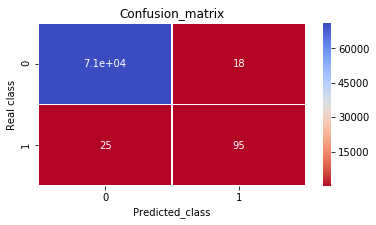

Classification Report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     71082
          1       0.84      0.79      0.82       120

avg / total       1.00      1.00      1.00     71202

The loss is :  39.50556047197641


In [167]:
print "the model classification for 132 proportion"
optimal_lr = LogisticRegression(C=0.1, penalty='l1', random_state=0)
prediction_algorithms(optimal_lr, X_undersample_train_lr, X_test_lr, y_undersample_train_lr, y_test_lr)

### Support Vector Machine (kernel='rbf')
#### C, gamma

In [9]:
undersample_data_svm = undersample(df_fe, normal_indices,fraud_indices, 25)
X_undersample_svm = undersample_data_svm.iloc[:, undersample_data_svm.columns != "Class"]
y_undersample_svm = undersample_data_svm.iloc[:, undersample_data_svm.columns == "Class"]
X_undersample_train_svm, X_undersample_test_svm, y_undersample_train_svm, y_undersample_test_svm = train_test_split(X_undersample_svm, y_undersample_svm, random_state=0)
X_svm = df_fe.iloc[:, df_fe.columns != "Class"]
y_svm = df_fe.iloc[:, df_fe.columns == "Class"]
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_svm, y_svm, random_state=0) 

the normal transacation proportion is : 0.961538461538
the fraud transacation proportion is : 0.0384615384615
total number of record in resampled data is: 12792


In [28]:
def Kfold_tuning_svm(X_train_data, y_train_data):
    fold = KFold(n_splits=5, shuffle=False, random_state=0) 

    c_param_range = [0.1, 1, 2, 5]
    gamma_range = [0.01, 0.1, 'auto', 1]

    c_list = []
    gamma_list = []
    mean_loss_list = []
    
    j = 0
    for c_param in c_param_range:
        print '-------------------------------------------'
        print 'C parameter: ', c_param
        print '-------------------------------------------'
        for gamma in gamma_range:
            print '-------------------------------------------'
            print 'Gamma: ', gamma
            print '-------------------------------------------'
            print ''

            loss_list = []
            for k, (train, test) in enumerate(fold.split(X_train_data, y_train_data)):

                # Call the logistic regression model with a certain C parameter
                svm = SVC(C=c_param, gamma=gamma, random_state=0)

                # Calculate the custom loss and append it to a list for loss representing the current c_parameter
                loss = custom_loss_fuction(svm, X_train_data.iloc[train], X_test_svm, y_train_data.iloc[train], y_test_svm)
                loss_list.append(loss)
                print 'Fold ', k + 1,': loss = ', loss

            j += 1
            print ''
            print 'Mean loss', np.mean(loss_list)
            print ''
            gamma_list.append(gamma)
            c_list.append(c_param)
            mean_loss_list.append(np.mean(loss_list))
    results_table = pd.DataFrame(index = range(len(mean_loss_list)), columns = ['C_parameter','Gamma', 'Mean loss'])
    results_table['Gamma'] = gamma_list
    results_table['C_parameter'] = c_list
    results_table['Mean loss'] = mean_loss_list
        
    best_gamma = results_table.loc[results_table['Mean loss'].idxmin()]['Gamma']
    best_c = results_table.loc[results_table['Mean loss'].idxmin()]['C_parameter']
    
    print results_table
    print  ''
    
    # Finally, we can check which C parameter is the best amongst the chosen.
    print '************************************************************************************'
    print 'Best model to choose from cross validation is with C = ', best_c, 'and best gamma = ', best_gamma
    print '************************************************************************************'
    
    return Kfold_tuning_svm

In [29]:
best_parameters_svm = Kfold_tuning_svm(X_undersample_train_svm, y_undersample_train_svm)

-------------------------------------------
C parameter:  0.1
-------------------------------------------
-------------------------------------------
Gamma:  0.01
-------------------------------------------



/Users/marcus/venv0/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  


Fold  1 : loss =  nan
Fold  2 : loss =  nan
Fold  3 : loss =  nan
Fold  4 : loss =  nan
Fold  5 : loss =  nan

Mean loss nan

-------------------------------------------
Gamma:  0.1
-------------------------------------------

Fold  1 : loss =  nan
Fold  2 : loss =  nan
Fold  3 : loss =  nan
Fold  4 : loss =  nan
Fold  5 : loss =  nan

Mean loss nan

-------------------------------------------
Gamma:  auto
-------------------------------------------

Fold  1 : loss =  nan
Fold  2 : loss =  nan
Fold  3 : loss =  nan
Fold  4 : loss =  nan
Fold  5 : loss =  nan

Mean loss nan

-------------------------------------------
Gamma:  1
-------------------------------------------

Fold  1 : loss =  nan
Fold  2 : loss =  nan
Fold  3 : loss =  nan
Fold  4 : loss =  nan
Fold  5 : loss =  nan

Mean loss nan

-------------------------------------------
C parameter:  1
-------------------------------------------
-------------------------------------------
Gamma:  0.01
---------------------------------

the model classification for 25 proportion
the recall for this model is : 0.7916666666666666
The accuracy is : 0.9996488862672397
TP 95
TN 71082
FP 0
FN 25


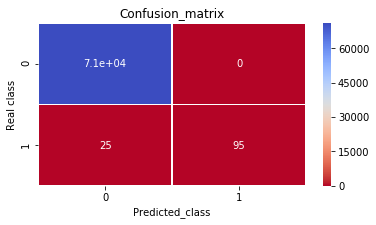

Classification Report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     71082
          1       1.00      0.79      0.88       120

avg / total       1.00      1.00      1.00     71202

The loss is :  25.441666666666674


In [31]:
print "the model classification for 25 proportion"
optimal_svm = SVC(gamma=0.1, random_state=0)
prediction_algorithms(optimal_svm, X_undersample_train_svm, X_test_svm, y_undersample_train_svm, y_test_svm)

### Random Forest
#### n_estimators, max_features, max_depth
***

In [34]:
undersample_data_rf = undersample(df_fe, normal_indices,fraud_indices, 40)
X_undersample_rf = undersample_data_rf.iloc[:, undersample_data_rf.columns != "Class"]
y_undersample_rf = undersample_data_rf.iloc[:, undersample_data_rf.columns == "Class"]
X_undersample_train_rf, X_undersample_test_rf, y_undersample_train_rf, y_undersample_test_rf = train_test_split(X_undersample_rf, y_undersample_rf, random_state=0)
X_rf = df_fe.iloc[:, df_fe.columns != "Class"]
y_rf = df_fe.iloc[:, df_fe.columns == "Class"]
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, random_state=0) 

the normal transacation proportion is : 0.975609756098
the fraud transacation proportion is : 0.0243902439024
total number of record in resampled data is: 20172


In [194]:
def Kfold_tuning_rf(X_train_data, y_train_data):
    fold = KFold(n_splits=5, shuffle=False, random_state=0) 

    n_estimators_range = [10, 100, 150, 200]
    max_features_type = ['auto', 'log2']
    max_depth_range = [10, 20, 30, None]
    n_estimators_list = []
    max_features_list = []
    max_depth_list = []
    mean_loss_list = []

    j = 0
    for n_estimators in n_estimators_range:
        print '-------------------------------------------'
        print 'n_estimators: ', n_estimators
        print '-------------------------------------------'
        for max_features in max_features_type:
            print '-------------------------------------------'
            print 'max_features: ', max_features
            print '-------------------------------------------'
            for max_depth in max_depth_range:
                print '-------------------------------------------'
                print 'max_depth: ', max_depth
                print '-------------------------------------------'

                loss_list = []
                for k, (train, test) in enumerate(fold.split(X_train_data, y_train_data)):

                    rf = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth, random_state=0)

                    loss = custom_loss_fuction(rf, X_train_data.iloc[train], X_test_rf, y_train_data.iloc[train], y_test_rf)
                    loss_list.append(loss)
                    print 'Fold ', k + 1,': loss = ', loss

                j += 1
                print ''
                print 'Mean loss', np.mean(loss_list)
                print ''
                n_estimators_list.append(n_estimators)
                max_features_list.append(max_features)
                max_depth_list.append(max_depth)
                mean_loss_list.append(np.mean(loss_list))
    results_table = pd.DataFrame(index = range(len(mean_loss_list)), columns = ['n_estimators', 'max_features', 'max_depth', 'Mean loss'])
    results_table['n_estimators'] = n_estimators_list
    results_table['max_features'] = max_features_list
    results_table['max_depth'] = max_depth_list
    results_table['Mean loss'] = mean_loss_list
        
    best_n_estimators = results_table.loc[results_table['Mean loss'].idxmin()]['n_estimators']
    best_max_features = results_table.loc[results_table['Mean loss'].idxmin()]['max_features']
    best_max_depth = results_table.loc[results_table['Mean loss'].idxmin()]['max_depth']
    
    print results_table
    print  ''
    
    print '**************************************************************************************************'
    print "Best model to choose from cross validation is with n_estimators = ", best_n_estimators, ", best max_features = ", best_max_features
    print "and best max_depth = ", best_max_depth
    print '**************************************************************************************************'
    
    return Kfold_tuning_rf

In [195]:
best_parameters_rf = Kfold_tuning_rf(X_undersample_train_rf, y_undersample_train_rf)

-------------------------------------------
n_estimators:  10
-------------------------------------------
-------------------------------------------
max_features:  auto
-------------------------------------------
-------------------------------------------
max_depth:  10
-------------------------------------------
Fold  1 : loss =  42.28242857142858
Fold  2 : loss =  44.50055172413794
Fold  3 : loss =  44.88126582278481
Fold  4 : loss =  42.438458333333344
Fold  5 : loss =  37.8631145038168

Mean loss 42.3931637911003

-------------------------------------------
max_depth:  20
-------------------------------------------
Fold  1 : loss =  34.99019607843138
Fold  2 : loss =  32.8756170212766
Fold  3 : loss =  28.178500000000007
Fold  4 : loss =  30.065695749440714
Fold  5 : loss =  27.447642857142856

Mean loss 30.71153034125831

-------------------------------------------
max_depth:  30
-------------------------------------------
Fold  1 : loss =  33.72066666666668
Fold  2 : loss =  32

Fold  1 : loss =  24.774617117117117
Fold  2 : loss =  24.010965034965043
Fold  3 : loss =  24.083066666666667
Fold  4 : loss =  25.92620408163266
Fold  5 : loss =  24.307925170068025

Mean loss 24.620555614089902

-------------------------------------------
n_estimators:  200
-------------------------------------------
-------------------------------------------
max_features:  auto
-------------------------------------------
-------------------------------------------
max_depth:  10
-------------------------------------------
Fold  1 : loss =  36.04908457711443
Fold  2 : loss =  36.697378787878804
Fold  3 : loss =  35.53386967418547
Fold  4 : loss =  37.72563184079603
Fold  5 : loss =  35.01084848484849

Mean loss 36.203362672964644

-------------------------------------------
max_depth:  20
-------------------------------------------
Fold  1 : loss =  24.307925170068025
Fold  2 : loss =  24.49975000000001
Fold  3 : loss =  23.1603963963964
Fold  4 : loss =  25.457232876712336
Fold  5

It seems tuning these 3 hyperparameters does nothing to the result. The optimal result is given by n_estimators=100, max_features='auto' and max_depth=30(same as None) which is the default model we used in the former part. Try out min_samples_split ,min_samples_leaf and other number of max_features.
***

In [37]:
def Kfold_tuning_rf1(X_train_data, y_train_data):
    fold = KFold(n_splits=5, shuffle=False, random_state=0) 

    max_features_range = ['auto', 1, 2, 8]
    min_samples_split_range = [2, 4, 8]
    min_samples_leaf_range = [1, 2, 4]

    max_features_list = []
    min_samples_split_list = []
    min_samples_leaf_list = []
    mean_loss_list = []

    j = 0
    for max_features in max_features_range:
        print '-------------------------------------------'
        print 'max_features: ', max_features
        print '-------------------------------------------'
        for min_samples_split in min_samples_split_range:
            print '-------------------------------------------'
            print 'min_samples_split: ', min_samples_split
            print '-------------------------------------------'
            for min_samples_leaf in min_samples_leaf_range:
                print '-------------------------------------------'
                print 'min_samples_leaf: ', min_samples_leaf
                print '-------------------------------------------'

                loss_list = []
                for k, (train, test) in enumerate(fold.split(X_train_data, y_train_data)):

                    rf = RandomForestClassifier(n_estimators=100, max_features=max_features, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=0)

                    loss = custom_loss_fuction(rf, X_train_data.iloc[train], X_test_rf, y_train_data.iloc[train], y_test_rf)
                    loss_list.append(loss)
                    print 'Fold ', k + 1,': loss = ', loss

                j += 1
                print ''
                print 'Mean loss', np.mean(loss_list)
                print ''
                max_features_list.append(max_features)
                min_samples_split_list.append(min_samples_split)
                min_samples_leaf_list.append(min_samples_leaf)
                mean_loss_list.append(np.mean(loss_list))
    results_table = pd.DataFrame(index = range(len(mean_loss_list)), columns = ['max_features', 'min_samples_split', 'min_samples_leaf', 'Mean loss'])
    results_table['max_features'] = max_features_list
    results_table['min_samples_split'] = min_samples_split_list
    results_table['min_samples_leaf'] = min_samples_leaf_list
    results_table['Mean loss'] = mean_loss_list
        
    best_max_features = results_table.loc[results_table['Mean loss'].idxmin()]['max_features']
    best_min_samples_split = results_table.loc[results_table['Mean loss'].idxmin()]['min_samples_split']
    best_min_samples_leaf = results_table.loc[results_table['Mean loss'].idxmin()]['min_samples_leaf']
    
    print results_table
    print  ''
    
    print '**************************************************************************************************'
    print "Best model to choose from cross validation is with best max_features = ", best_max_features, ", best min_samples_split = ", best_min_samples_split
    print "and best min_samples_leaf = ", best_min_samples_leaf
    print '**************************************************************************************************'
    
    return Kfold_tuning_rf1

In [38]:
best_parameters_rf1 = Kfold_tuning_rf1(X_undersample_train_rf, y_undersample_train_rf)

-------------------------------------------
max_features:  auto
-------------------------------------------
-------------------------------------------
min_samples_split:  2
-------------------------------------------
-------------------------------------------
min_samples_leaf:  1
-------------------------------------------
Fold  1 : loss =  23.834840182648392
Fold  2 : loss =  23.012595744680862
Fold  3 : loss =  23.624827740492172
Fold  4 : loss =  25.457232876712336
Fold  5 : loss =  24.774617117117117

Mean loss 24.14082273233018

-------------------------------------------
min_samples_leaf:  2
-------------------------------------------
Fold  1 : loss =  36.04908457711443
Fold  2 : loss =  36.17147837150128
Fold  3 : loss =  37.54960097323601
Fold  4 : loss =  39.211720194647214
Fold  5 : loss =  36.04908457711443

Mean loss 37.00619373872267

-------------------------------------------
min_samples_leaf:  4
-------------------------------------------
Fold  1 : loss =  38.38390909

Fold  1 : loss =  33.94066666666666
Fold  2 : loss =  37.8631145038168
Fold  3 : loss =  33.39313178294574
Fold  4 : loss =  35.637487179487195
Fold  5 : loss =  35.09521705426358

Mean loss 35.185923437435996

-------------------------------------------
min_samples_leaf:  4
-------------------------------------------
Fold  1 : loss =  35.69792125984252
Fold  2 : loss =  37.8631145038168
Fold  3 : loss =  36.797302325581406
Fold  4 : loss =  39.12364829396324
Fold  5 : loss =  37.95933854166667

Mean loss 37.48826498497412

-------------------------------------------
min_samples_split:  8
-------------------------------------------
-------------------------------------------
min_samples_leaf:  1
-------------------------------------------
Fold  1 : loss =  34.54447395833334
Fold  2 : loss =  37.8631145038168
Fold  3 : loss =  35.09521705426358
Fold  4 : loss =  37.95933854166667
Fold  5 : loss =  36.797302325581406

Mean loss 36.45188927673236

-----------------------------------------

* the optimal min_samples_split and min_samples_leaf are all default value.
* optimal max_features could not be decided by the above grid search because 1 is the lower bound of our max_features_range. Thus, more numbers less than 1 should be tried.
***

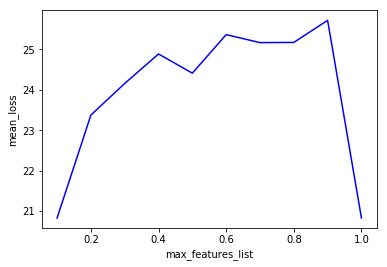

In [43]:
fold = KFold(n_splits=5, shuffle=False, random_state=0) 
mean_loss = []
max_features_list = []
for i in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    loss_list = []
    for k, (train, test) in enumerate(fold.split(X_undersample_train_rf, y_undersample_train_rf)):
        rf = RandomForestClassifier(n_estimators=100, max_features=i, random_state=0)
        loss = custom_loss_fuction(rf, X_undersample_train_rf.iloc[train], X_test_rf, y_undersample_train_rf.iloc[train], y_test_rf)
        loss_list.append(loss)
    mean_loss.append(np.mean(loss_list))
    max_features_list.append(i)
plt.plot(max_features_list, mean_loss, '-b')
plt.ylabel('mean_loss')
plt.xlabel('max_features_list')
plt.show()

min_loss = np.min(mean_loss)
min_loss_index = mean_loss.index(min_loss)
optimal_max_features = max_features_list[min_loss_index]

In [44]:
print optimal_max_features, min_loss

0.1 20.82992691426936


* Not any big difference here. The optimal max_features would still be selected as 1.

#### Optimal Random Forest Model
* n_estimators=100, max_features=1; max_depth, min_samples_split and min_samples_leaf equals to default value.
***

the model classification for 40 proportion
the recall for this model is : 0.9833333333333333
The accuracy is : 0.9996488862672397
TP 118
TN 71059
FP 23
FN 2


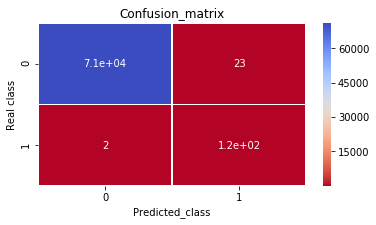

Classification Report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     71082
          1       0.84      0.98      0.90       120

avg / total       1.00      1.00      1.00     71202

The loss is :  16.437248226950363


In [46]:
print "the model classification for 40 proportion"
optimal_rf = RandomForestClassifier(n_estimators=100, max_features=1, random_state=0)
prediction_algorithms(optimal_rf, X_undersample_train_rf, X_test_rf, y_undersample_train_rf, y_test_rf)

### Gradient Boosting Tree
***

In [220]:
df_gbt = df.loc[:, ['V11', 'V17', 'V14', 'V10', 'V12', 'V4', 'Class']]
undersample_data_gbt = undersample(df_gbt, normal_indices,fraud_indices, 79)
X_undersample_gbt = undersample_data_gbt.iloc[:, undersample_data_gbt.columns != "Class"]
y_undersample_gbt = undersample_data_gbt.iloc[:, undersample_data_gbt.columns == "Class"]
X_undersample_train_gbt, X_undersample_test_gbt, y_undersample_train_gbt, y_undersample_test_gbt = train_test_split(X_undersample_gbt, y_undersample_gbt, random_state=0)
X_gbt = df_gbt.iloc[:, df_gbt.columns != "Class"]
y_gbt = df_gbt.iloc[:, df_gbt.columns == "Class"]
X_train_gbt, X_test_gbt, y_train_gbt, y_test_gbt = train_test_split(X_gbt, y_gbt, random_state=0) 

the normal transacation proportion is : 0.9875
the fraud transacation proportion is : 0.0125
total number of record in resampled data is: 39360


#### Fixed learning rate, tuning n_estimators, max_depth, min_samples_split
***

In [221]:
def Kfold_tuning_gbt(X_train_data, y_train_data):
    fold = KFold(n_splits=5, shuffle=False, random_state=0) 

    n_estimators_range = [100, 200, 300]
    max_depth_range = [3, 5, 7, 9]
    min_samples_split_range = [2, 4, 8, 16]
    n_estimators_list = []
    max_depth_list = []
    min_samples_split_list = []
    mean_loss_list = []

    j = 0
    for n_estimators in n_estimators_range:
        print '-------------------------------------------'
        print 'n_estimators: ', n_estimators
        print '-------------------------------------------'
        for max_depth in max_depth_range:
            print '-------------------------------------------'
            print 'max_depth: ', max_depth
            print '-------------------------------------------'
            for min_samples_split in min_samples_split_range:
                print '-------------------------------------------'
                print 'min_samples_split: ', min_samples_split
                print '-------------------------------------------'

                loss_list = []
                for k, (train, test) in enumerate(fold.split(X_train_data, y_train_data)):

                    gbt = GradientBoostingClassifier(n_estimators=n_estimators,max_depth=max_depth, min_samples_split=min_samples_split, random_state=0)

                    loss = custom_loss_fuction(gbt, X_train_data.iloc[train], X_test_gbt, y_train_data.iloc[train], y_test_gbt)
                    loss_list.append(loss)
                    print 'Fold ', k + 1,': loss = ', loss

                j += 1
                print ''
                print 'Mean loss', np.mean(loss_list)
                print ''
                n_estimators_list.append(n_estimators)
                max_depth_list.append(max_depth)
                min_samples_split_list.append(min_samples_split)
                mean_loss_list.append(np.mean(loss_list))
    results_table = pd.DataFrame(index = range(len(mean_loss_list)), columns = ['n_estimators', 'max_depth', 'min_samples_split', 'Mean loss'])
    results_table['n_estimators'] = n_estimators_list
    results_table['max_depth'] = max_depth_list
    results_table['min_samples_split'] = min_samples_split_list
    results_table['Mean loss'] = mean_loss_list
        
    best_n_estimators = results_table.loc[results_table['Mean loss'].idxmin()]['n_estimators']
    best_max_depth = results_table.loc[results_table['Mean loss'].idxmin()]['max_depth']
    best_min_samples_split = results_table.loc[results_table['Mean loss'].idxmin()]['min_samples_split']
    
    print results_table
    print  ''
    
    # Finally, we can check which C parameter is the best amongst the chosen.
    print '**************************************************************************************************'
    print "Best model to choose from cross validation is with n_estimators = ", best_n_estimators, "and best max_depth = ", best_max_depth
    print "and best min_samples_split = ", best_min_samples_split 
    print '**************************************************************************************************'
    
    return Kfold_tuning_gbt

In [222]:
best_parameters_gbt = Kfold_tuning_gbt(X_undersample_train_gbt, y_undersample_train_gbt)

-------------------------------------------
n_estimators:  100
-------------------------------------------
-------------------------------------------
max_depth:  3
-------------------------------------------
-------------------------------------------
min_samples_split:  2
-------------------------------------------
Fold  1 : loss =  52.696056497175135
Fold  2 : loss =  61.09985123966941
Fold  3 : loss =  57.32602898550725
Fold  4 : loss =  60.6234329004329
Fold  5 : loss =  58.96547747747748

Mean loss 58.14216942005244

-------------------------------------------
min_samples_split:  4
-------------------------------------------
Fold  1 : loss =  55.897054644808755
Fold  2 : loss =  57.15963636363636
Fold  3 : loss =  59.607333333333344
Fold  4 : loss =  57.758673046252
Fold  5 : loss =  56.96172602739726

Mean loss 57.476884683085544

-------------------------------------------
min_samples_split:  8
-------------------------------------------
Fold  1 : loss =  58.98552884615385
Fold

Fold  1 : loss =  51.07133333333333
Fold  2 : loss =  48.89056410256411
Fold  3 : loss =  46.26701642036126
Fold  4 : loss =  49.40885294117648
Fold  5 : loss =  53.89259999999999

Mean loss 49.90607335948703

-------------------------------------------
max_depth:  7
-------------------------------------------
-------------------------------------------
min_samples_split:  2
-------------------------------------------
Fold  1 : loss =  45.041566844919785
Fold  2 : loss =  43.83303546099292
Fold  3 : loss =  43.72055785837652
Fold  4 : loss =  47.19161538461539
Fold  5 : loss =  46.67081347150258

Mean loss 45.29151780408144

-------------------------------------------
min_samples_split:  4
-------------------------------------------
Fold  1 : loss =  47.19161538461539
Fold  2 : loss =  41.495333333333335
Fold  3 : loss =  44.92883333333333
Fold  4 : loss =  48.448049999999995
Fold  5 : loss =  48.448049999999995

Mean loss 46.10237641025641

-------------------------------------------


Fold  3 : loss =  40.564214689265526
Fold  4 : loss =  42.08069491525424
Fold  5 : loss =  52.69927397260274

Mean loss 48.928426240718615

-------------------------------------------
min_samples_split:  16
-------------------------------------------
Fold  1 : loss =  48.66089855072464
Fold  2 : loss =  51.07133333333333
Fold  3 : loss =  37.40918992248063
Fold  4 : loss =  46.93255670103093
Fold  5 : loss =  45.041566844919785

Mean loss 45.823109070497864

    n_estimators  max_depth  min_samples_split  Mean loss
0            100          3                  2  58.142169
1            100          3                  4  57.476885
2            100          3                  8  59.926028
3            100          3                 16  55.778580
4            100          5                  2  52.644200
5            100          5                  4  53.104302
6            100          5                  8  53.731360
7            100          5                 16  52.686105
8            10

* The optimal n_estimators and min_samples_split are 200 and 2(default).
* The optimal max_depth could not be decided by the above grid search because 9 is the upper bound of our max_depth_range. Thus, more numbers larger than 9 should be tried.
***

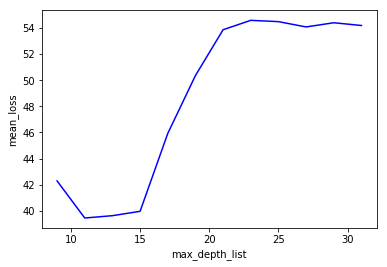

In [229]:
fold = KFold(n_splits=5, shuffle=False, random_state=0) 
mean_loss = []
max_depth_list = []
for i in range(9, 33, 2):
    loss_list = []
    for k, (train, test) in enumerate(fold.split(X_undersample_train_gbt, y_undersample_train_gbt)):
        gbt = GradientBoostingClassifier(n_estimators=200, max_depth=i)
        loss = custom_loss_fuction(gbt, X_undersample_train_gbt.iloc[train], X_test_gbt, y_undersample_train_gbt.iloc[train], y_test_gbt)
        loss_list.append(loss)
    mean_loss.append(np.mean(loss_list))
    max_depth_list.append(i)
plt.plot(max_depth_list, mean_loss, '-b')
plt.ylabel('mean_loss')
plt.xlabel('max_depth_list')
plt.show()

min_loss = np.min(mean_loss)
min_loss_index = mean_loss.index(min_loss)
optimal_max_depth = max_depth_list[min_loss_index]

In [240]:
## this is the optimal max_depth
optimal_max_depth, min_loss

(11, 39.439148611761915)

#### So far, we got optimal n_estimators=200, max_depth=11, min_samples_split=2(default).
#### Tuning subsample and making models with lower learning rate.
***

In [247]:
def Kfold_tuning_gbt1(X_train_data, y_train_data):
    fold = KFold(n_splits=5, shuffle=False, random_state=0) 

    subsample_range = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
    subsample_list = []
    mean_loss_list = []

    j = 0
    for subsample in subsample_range:
        print '-------------------------------------------'
        print 'subsample: ', subsample
        print '-------------------------------------------'
        loss_list = []
        for k, (train, test) in enumerate(fold.split(X_train_data, y_train_data)):

            gbt = GradientBoostingClassifier(n_estimators=200,max_depth=11, subsample=subsample, random_state=0)

            loss = custom_loss_fuction(gbt, X_train_data.iloc[train], X_test_gbt, y_train_data.iloc[train], y_test_gbt)
            loss_list.append(loss)
            print 'Fold ', k + 1,': loss = ', loss

        j += 1
        print ''
        print 'Mean loss', np.mean(loss_list)
        print ''
        subsample_list.append(subsample)
        mean_loss_list.append(np.mean(loss_list))
    results_table = pd.DataFrame(index = range(len(mean_loss_list)), columns = ['Subsample','Mean loss'])
    results_table['Subsample'] = subsample_list
    results_table['Mean loss'] = mean_loss_list

    best_subsample = results_table.loc[results_table['Mean loss'].idxmin()]['Subsample']

    print results_table
    print  ''

    # Finally, we can check which C parameter is the best amongst the chosen.
    print '*******************************************************************'
    print "Best model to choose from cross validation is with subsample = ", best_subsample
    print '*******************************************************************'

    return Kfold_tuning_gbt1

In [238]:
best_parameters_gbt1 = Kfold_tuning_gbt1(X_undersample_train_gbt, y_undersample_train_gbt)

-------------------------------------------
subsample:  0.6
-------------------------------------------
Fold  1 : loss =  48.448049999999995
Fold  2 : loss =  34.62833333333334
Fold  3 : loss =  48.91615646258504
Fold  4 : loss =  47.701842639593906
Fold  5 : loss =  53.50195964125561

Mean loss 46.63926841535358

-------------------------------------------
subsample:  0.65
-------------------------------------------
Fold  1 : loss =  42.345741134751776
Fold  2 : loss =  49.64319512195121
Fold  3 : loss =  53.89259999999999
Fold  4 : loss =  46.252150537634414
Fold  5 : loss =  53.50416666666667

Mean loss 49.12757069220081

-------------------------------------------
subsample:  0.7
-------------------------------------------
Fold  1 : loss =  44.38670175438597
Fold  2 : loss =  43.55176114081996
Fold  3 : loss =  42.97009523809525
Fold  4 : loss =  48.145941278065635
Fold  5 : loss =  47.08095238095239

Mean loss 45.22709035846384

-------------------------------------------
subsampl

#### When subsample = 0.9, the mean loss is 40.56 which is larger than the default one(39.44). Thus, the optimal subsample=default(1.0).
***

In [251]:
def Kfold_tuning_gbt2(X_train_data, y_train_data):
    fold = KFold(n_splits=5, shuffle=False, random_state=0) 

    learning_rate_range = [0.1, 0.05, 0.01, 0.005]
    n_estimators_range = [200, 400, 2000, 4000]
    mean_loss_list = []

    j = 0
    for i in range(0,4):
        print '-------------------------------------------'
        print 'learning_rate: ', learning_rate_range[i]
        print 'n_estimators: ', n_estimators_range[i]
        print '-------------------------------------------'
        loss_list = []
        for k, (train, test) in enumerate(fold.split(X_train_data, y_train_data)):

            gbt = GradientBoostingClassifier(learning_rate=learning_rate_range[i], n_estimators=n_estimators_range[i],max_depth=11, random_state=0)

            loss = custom_loss_fuction(gbt, X_train_data.iloc[train], X_test_gbt, y_train_data.iloc[train], y_test_gbt)
            loss_list.append(loss)
            print 'Fold ', k + 1,': loss = ', loss

        j += 1
        print ''
        print 'Mean loss', np.mean(loss_list)
        print ''
        mean_loss_list.append(np.mean(loss_list))
    results_table = pd.DataFrame(index = range(len(mean_loss_list)), columns = ['Learning_rate', 'N_estimators', 'Mean loss'])
    results_table['Learning_rate'] = learning_rate_range
    results_table['N_estimators'] = n_estimators_range
    results_table['Mean loss'] = mean_loss_list
    
    best_learning_rate = results_table.loc[results_table['Mean loss'].idxmin()]['Learning_rate']
    best_n_estimators = results_table.loc[results_table['Mean loss'].idxmin()]['N_estimators']

    print results_table
    print  ''

    # Finally, we can check which C parameter is the best amongst the chosen.
    print '*******************************************************************************************************************'
    print "Best model to choose from cross validation is with best learning rate = ", best_learning_rate, " and corresponding n_estimators = ", best_n_estimators
    print '*******************************************************************************************************************'


    return Kfold_tuning_gbt2

In [252]:
best_parameters_gbt2 = Kfold_tuning_gbt2(X_undersample_train_gbt, y_undersample_train_gbt)

-------------------------------------------
learning_rate:  0.1
n_estimators:  200
-------------------------------------------
Fold  1 : loss =  44.474999999999994
Fold  2 : loss =  34.99019607843138
Fold  3 : loss =  34.57970325203253
Fold  4 : loss =  39.11453571428571
Fold  5 : loss =  46.67081347150258

Mean loss 39.96604970325044

-------------------------------------------
learning_rate:  0.05
n_estimators:  400
-------------------------------------------
Fold  1 : loss =  36.57825465838509
Fold  2 : loss =  30.55128205128205
Fold  3 : loss =  31.047408602150544
Fold  4 : loss =  29.86148275862069
Fold  5 : loss =  39.80082352941176

Mean loss 33.56785031997003

-------------------------------------------
learning_rate:  0.01
n_estimators:  2000
-------------------------------------------
Fold  1 : loss =  29.392124999999993
Fold  2 : loss =  30.07300469483569
Fold  3 : loss =  29.342342163355408
Fold  4 : loss =  29.392124999999993
Fold  5 : loss =  41.126068965517234

Mean loss

#### Optimal GBT Model
* leanring_rate = 0.01, n_estimators = 2000, max_depth=11; min_samples_split, subsample equals to default.
***

the model classification for 79 proportion
the recall for this model is : 0.9583333333333334
The accuracy is : 0.9994663071262043
TP 115
TN 71049
FP 33
FN 5


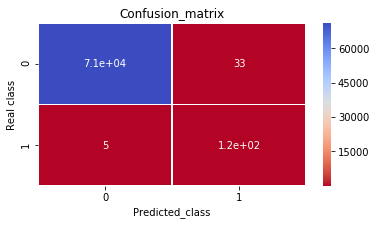

Classification Report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     71082
          1       0.78      0.96      0.86       120

avg / total       1.00      1.00      1.00     71202

The loss is :  24.774617117117117


In [253]:
print "the model classification for 79 proportion"
optimal_gbt = GradientBoostingClassifier(learning_rate=0.01, n_estimators=2000, max_depth=11, random_state=0)
prediction_algorithms(optimal_gbt, X_undersample_train_gbt, X_test_gbt, y_undersample_train_gbt, y_test_gbt)

## Conclusion of model selection
***

#### Model performances without resampling, pre-precessing or tunning hyperparameters:
|         Models         | Precision | Recall |  F1  | Accuracy | Custom Loss |
|:----------------------:|:---------:|:------:|:----:|:--------:|:-----------:|
|   Logistic Regression  |    0.81   |  0.60  | 0.69 |   0.99   |    65.62    |
| Support Vector Machine |    1.00   |  0.03  | 0.05 |   0.99   |    118.46   |
|      *Random Forest    |    0.94   |  0.75  | 0.83 |   0.99   |    35.83    | 
| Gradient Boosting Tree |    0.50   |  0.47  | 0.60 |   0.99   |    108.87   |

#### Optimal model performances after pre-processing and selection of optimal proportion:

* All the models perform better after selecting a appropriate proportion for undersampling especially for SVM and GBT.

* Random Forest is the best among the 4 models.

|         Models         | Precision | Recall |  F1  | Accuracy | Custom Loss | Diff vs 1st table |
|:----------------------:|:---------:|:------:|:----:|:--------:|:-----------:|:-----------------:|
|   Logistic Regression  |    0.71   |  0.74  | 0.73 |   0.99   |    57.35    |       -8.27      |
| Support Vector Machine |    1.00   |  0.78  | 0.88 |   0.99   |    26.87    |       -91.59      |
|      *Random Forest    |    0.81   |  0.98  | 0.89 |   0.99   |    19.22    |       -16.61      |
| Gradient Boosting Tree |    0.52   |  0.94  | 0.67 |   0.99   |    49.71    |       -59.16      |

#### Optimal model performances after tunning hyperparameters:

* All the models have got improvements from hyperparameters' tunning especially for Logistic Regression and Gradient Boosting Tree.

* In conclusion, SVM and Random Forest are more sensitive to the proportion of undersampling compared to tunning hyperparameters. Logistic Reregssion and GBT are sensetive to both of them.

* Random Forest is still the best amoung the 4 models. Actually the improvement after tunning hyperparameters is trivial for Support Vector Machine (non-linear) and Random Forest. Anyway, better than nothing. It still saves about $ 2.65 per (fraud + misclassification normal) transaction for us.

|         Models         | Precision | Recall |  F1  | Accuracy | Custom Loss | Diff vs 1st table | Diff vs 2nd table |
|:----------------------:|:---------:|:------:|:----:|:--------:|:-----------:|:-----------------:|:-----------------:|
|   Logistic Regression  |    0.84   |  0.79  | 0.82 |   0.99   |    39.78    |       -25.84      |       -17.57      |
| Support Vector Machine |    1.00   |  0.79  | 0.88 |   0.99   |    25.65    |       -92.81      |       -1.22       |
|      Random Forest     |    0.84   |  0.98  | 0.89 |   0.99   |    16.57    |       -19.26      |       -2.65       |
| Gradient Boosting Tree |    0.78   |  0.96  | 0.86 |   0.99   |    24.30    |       -84.57      |       -25.41      |

